In [ ]:
import pandas as pd
import numpy as np

In [ ]:

import torch

In [ ]:
df = pd.read_csv('macro_index_returns.csv')

In [ ]:
columns = ["RETX", "date","TICKER"]
df = df[columns]

def convert_to_number(x):
    try:
        return float(x)
    except:
        return None

df['ret_parsed'] = df['RETX'].apply(convert_to_number)

df["date"] = pd.to_datetime(df["date"])
df.set_index("date", inplace=True)
df.drop(columns=["RETX"], inplace=True)

df = df.pivot_table(index=df.index, columns="TICKER", values="ret_parsed", aggfunc="first")

df.dropna(inplace=True)

In [ ]:
# 2. Compute stable rolling z
def safe_rolling_zscore(df, window):
    rolling_mean = df.rolling(window).mean()
    rolling_std = df.rolling(window).std()

    # If std == 0 → return 0 instead of NaN or inf
    z = (df - rolling_mean) / rolling_std.replace(0, np.nan)
    z = z.fillna(0)

    return z

returns_df = safe_rolling_zscore(df, window=60)

# 3. Replace infinities / residual NaN
returns_df = returns_df.replace([np.inf, -np.inf], 0)

In [ ]:
rolling_vol_df  =df.rolling(60).std() * np.sqrt(252)

In [ ]:
rolling_vol_df = rolling_vol_df[60:]

In [ ]:
len(rolling_vol_df)

4160

In [ ]:
rolling_vol_df.head()

TICKER,GLD,IEF,SPY,USO,UUP
date,,,,,
2008-06-23,0.244043,0.074710,0.173774,0.356072,0.100404
2008-06-24,0.242178,0.075606,0.173672,0.346093,0.100544
2008-06-25,0.228262,0.071889,0.157800,0.350188,0.095844
2008-06-26,0.233413,0.072809,0.166927,0.353790,0.094608
2008-06-27,0.234150,0.073648,0.167010,0.353505,0.094526


In [ ]:
len(returns_df)

4279

In [ ]:
returns_df, rolling_vol_df = returns_df.align(rolling_vol_df, join='inner')


In [ ]:
df, rolling_vol_df = df.align(rolling_vol_df, join='inner')

training section

In [ ]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
# Suppose returns_df and rolling_vol_df have the same index
T = len(returns_df)

returns_df = df

train_ratio = 0.8
split_idx = int(T * train_ratio)

returns_train = returns_df.iloc[:split_idx]
returns_test  = returns_df.iloc[split_idx:]

vol_train = rolling_vol_df.iloc[:split_idx]
vol_test  = rolling_vol_df.iloc[split_idx:]


In [ ]:
window = 20  # past window size (days)

# ----- TRAIN SET -----
X_train, vol_train_list, y_train = [], [], []

for t in range(window, len(returns_train) - 1):
    past = returns_train.iloc[t-window:t].values.flatten()
    vol_t = vol_train.iloc[t].values
    y_t1  = returns_train.iloc[t+1].values

    X_train.append(past)
    vol_train_list.append(vol_t)
    y_train.append(y_t1)

X_train = np.array(X_train, dtype=np.float32)
vol_train_list = np.array(vol_train_list, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)

# ----- TEST SET -----
X_test, vol_test_list, y_test = [], [], []

for t in range(window, len(returns_test) - 1):
    past = returns_test.iloc[t-window:t].values.flatten()
    vol_t = vol_test.iloc[t].values
    y_t1  = returns_test.iloc[t+1].values

    X_test.append(past)
    vol_test_list.append(vol_t)
    y_test.append(y_t1)

X_test = np.array(X_test, dtype=np.float32)
vol_test_list = np.array(vol_test_list, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)



In [ ]:
class MacroPortfolioDataset(Dataset):
    def __init__(self, X, vol, y):
        self.X = torch.from_numpy(X)      # (N, D)
        self.vol = torch.from_numpy(vol)  # (N, 5)
        self.y = torch.from_numpy(y)      # (N, 5)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.vol[idx], self.y[idx]


In [ ]:
train_dataset = MacroPortfolioDataset(X_train, vol_train_list, y_train)
test_dataset  = MacroPortfolioDataset(X_test,  vol_test_list,  y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=256, shuffle=False)



In [ ]:
class MacroPortfolioNet(nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 6)  # 5 risky + 1 cash
        )

    def forward(self, x, vol):
        """
        x: (batch, D)        - features
        vol: (batch, 5)      - rolling vol for each asset (positive)
        Returns:
            weights: (batch, 6) - 5 risky + 1 cash
        """
        logits = self.net(x)          # (batch, 6)
        risk_scores = logits[:, :5]   # (batch, 5)
        cash_logit = logits[:, 5]     # (batch,)

        # ---- Cash weight (long-only, in [0,1]) ----
        cash_weight = torch.sigmoid(cash_logit)  # (batch,)
        risk_budget = 1.0 - cash_weight         # fraction of capital in risky assets

        # ---- Vol-normalized risky directions ----
        eps = 1e-8
        vol_adj = risk_scores / (vol + eps)     # (batch, 5)

        # Normalize so sum |weights| = 1 for the risky component
        abs_sum = torch.sum(torch.abs(vol_adj), dim=1, keepdim=True) + eps
        risk_dir = vol_adj / abs_sum            # (batch, 5), sum |risk_dir| = 1

        # Scale by risk budget
        risky_weights = risk_dir * risk_budget.unsqueeze(1)  # (batch, 5)

        # Stack with cash
        cash_weight = cash_weight.unsqueeze(1)  # (batch, 1)
        weights = torch.cat([risky_weights, cash_weight], dim=1)  # (batch, 6)
        return weights


In [ ]:
def sharpe_ratio_loss(portfolio_returns, eps=1e-6):
    """
    portfolio_returns: (batch,) tensor of daily portfolio returns
    Returns: loss = -Sharpe
    """
    mean = portfolio_returns.mean()
    std = portfolio_returns.std(unbiased=False) + eps
    sharpe = mean / std
    return -sharpe


def mean_variance_loss(port_ret, risky_w, lambda_risk=1.0, lambda_lev=1e-3, eps=1e-8):
    """
    port_ret: (batch,) portfolio returns
    risky_w:  (batch, 5) risky weights only
    """
    mean_ret = port_ret.mean()
    var_ret  = port_ret.var(unbiased=False)

    # leverage penalty (squared L2 of risky weights)
    lev_penalty = (risky_w.pow(2).sum(dim=1)).mean()

    loss = -mean_ret + lambda_risk * var_ret + lambda_lev * lev_penalty
    return loss



In [ ]:
input_dim = X_train.shape[1]
model = MacroPortfolioNet(input_dim=input_dim, hidden_dim=3)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Assume cash has zero return (or plug in a risk-free rate series if you want)
risk_free = 0.0

num_epochs = 500

model.train()


for epoch in range(num_epochs):
    model.train()
    epoch_losses = []

    for batch_X, batch_vol, batch_y in train_loader:
        optimizer.zero_grad()

        w = model(batch_X, batch_vol)
        risky_w = w[:, :5]
        cash_w = w[:, 5]

        risky_ret = (risky_w * batch_y).sum(dim=1)
        port_ret  = risky_ret   # cash ~ 0

        # loss = mean_variance_loss(port_ret, risky_w)
        loss = sharpe_ratio_loss(port_ret)
        loss.backward()
        optimizer.step()

        epoch_losses.append(loss.item())

    print(f"Epoch {epoch+1}, Train Loss: {np.mean(epoch_losses):.4f}")



Epoch 1, Train Loss: -0.0744
Epoch 2, Train Loss: -0.0810
Epoch 3, Train Loss: -0.0824
Epoch 4, Train Loss: -0.0771
Epoch 5, Train Loss: -0.0814
Epoch 6, Train Loss: -0.0856
Epoch 7, Train Loss: -0.0866
Epoch 8, Train Loss: -0.0844
Epoch 9, Train Loss: -0.0891
Epoch 10, Train Loss: -0.0903
Epoch 11, Train Loss: -0.0906
Epoch 12, Train Loss: -0.0867
Epoch 13, Train Loss: -0.0861
Epoch 14, Train Loss: -0.0914
Epoch 15, Train Loss: -0.0909
Epoch 16, Train Loss: -0.0986
Epoch 17, Train Loss: -0.0966
Epoch 18, Train Loss: -0.0964
Epoch 19, Train Loss: -0.0995
Epoch 20, Train Loss: -0.0927
Epoch 21, Train Loss: -0.1035
Epoch 22, Train Loss: -0.1004
Epoch 23, Train Loss: -0.1022
Epoch 24, Train Loss: -0.1099
Epoch 25, Train Loss: -0.1071
Epoch 26, Train Loss: -0.1119
Epoch 27, Train Loss: -0.1139
Epoch 28, Train Loss: -0.1226
Epoch 29, Train Loss: -0.1136
Epoch 30, Train Loss: -0.1179
Epoch 31, Train Loss: -0.1215
Epoch 32, Train Loss: -0.1193
Epoch 33, Train Loss: -0.1201
Epoch 34, Train Los

In [ ]:
model.eval()
test_returns = []

with torch.no_grad():
    for batch_X, batch_vol, batch_y in test_loader:
        w = model(batch_X, batch_vol)
        risky_w = w[:, :5]

        port_ret = (risky_w * batch_y).sum(dim=1)
        test_returns.append(port_ret.numpy())

test_returns = np.concatenate(test_returns)
test_sharpe = test_returns.mean() / test_returns.std()

print("Test Sharpe:", test_sharpe)


Test Sharpe: 0.032132305


In [ ]:
np.sum(test_returns>=0)/len(test_returns)

np.float64(0.5055487053020962)

In [ ]:
max(test_returns)

np.float32(0.013753043)

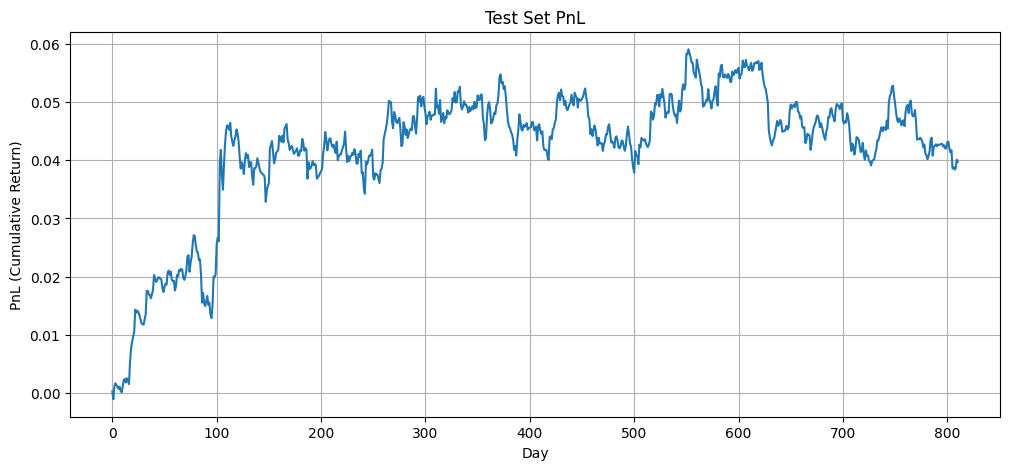

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Suppose test_returns is a 1D numpy array of daily portfolio returns
test_returns = np.array(test_returns)

# Compute cumulative PnL (starting at 0 or starting at 1, choose one)
# cumulative_pnl = np.cumprod(1 + test_returns) - 1  # cumulative return
# or:
cumulative_pnl = np.cumsum(test_returns)          # raw PnL

plt.figure(figsize=(12,5))
plt.plot(cumulative_pnl)
plt.title("Test Set PnL")
plt.xlabel("Day")
plt.ylabel("PnL (Cumulative Return)")
plt.grid(True)
plt.show()
